In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from sindy_utils import library_size
import tensorflow as tf
import matplotlib.pyplot as plt
from training import train_network


c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\frame

In [2]:
def rolling_average_with_stride(df, window_size, stride):
    result = pd.concat([df.iloc[i:i+window_size].agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.mode().iloc[0])
                       for i in range(0, len(df), stride)], axis=1).T.reset_index(drop=True)

    return result[df.columns]

def split_data(data_dict, validation_ratio=0.2, seed=None):
    """
    Splits the data dictionary into training and validation sets.

    Parameters:
        data_dict (dict): The data dictionary with 'x' and 'dx' arrays.
        validation_ratio (float): The ratio of validation data (default: 0.2).
        seed (int): Seed for random number generator (optional).

    Returns:
        tuple: Two dictionaries: (training_dict, validation_dict).
    """
    

    x_array = data_dict['x']
    dx_array = data_dict['dx']
    class_ = data_dict['classes']

    # Get the number of samples
    num_samples = x_array.shape[0]
        
    # Shuffle the indices of the samples
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Calculate the size of the validation set
    validation_size = int(num_samples * validation_ratio)

    # Get the indices for validation and training sets
    validation_indices = indices[:validation_size]
    training_indices = indices[validation_size:]
    # print('Training classes',np.sum(class_[training_indices], axis=0) )
    # print('Validation classes', class_.nunique())


    # Create the training and validation dictionaries
    training_dict = {
        'x': x_array[training_indices],
        'dx': dx_array[training_indices],
        'classes': class_[training_indices]
    }

    validation_dict = {
        'x': x_array[validation_indices],
        'dx': dx_array[validation_indices],
        'classes': class_[validation_indices]

    }

    return training_dict, validation_dict
def xavier_initializer(shape):
    """
    Xavier initializer for weights.
    
    Arguments:
        shape (tuple): Shape of the weight tensor.
    
    Returns:
        np.ndarray: Initialized weight tensor.
    """
    variance = 2.0 / (shape[0] + shape[1])  # Xavier variance calculation
    stddev = np.sqrt(variance)
    return np.random.normal(0, stddev, shape)

def build_network_layers(input_dim, output_dim, widths, name):
    """
    Construct one portion of the network (either encoder or decoder).
    Arguments:
        input (Tensor): 2D TensorFlow array, input to the network (shape is [?, input_dim]).
        input_dim (int): Integer, number of state variables in the input to the first layer.
        output_dim (int): Integer, number of state variables to output from the final layer.
        widths (List[int]): List of integers representing how many units are in each network layer.
        activation (function): TensorFlow activation function to be used at each layer.
        name (str): Prefix to be used in naming the TensorFlow variables.
    Returns:
        output (Tensor): TensorFlow array, output of the network layers (shape is [?, output_dim]).
        weights (List[Tensor]): List of TensorFlow arrays containing the network weights.
        biases (List[Tensor]): List of TensorFlow arrays containing the network biases.
    """
    weights = []
    last_width = input_dim
    for i, n_units in enumerate(widths):
        W = np.float32(xavier_initializer(shape=[last_width, n_units]))
        last_width = n_units
        weights.append(W)
    W = np.float32(xavier_initializer(shape=[last_width, output_dim]))
    weights.append(W)
    if name=="encoder":
        W = np.float32(xavier_initializer(shape=[last_width, output_dim]))
        weights.append(W)
    
    return weights
def coefficient_innit(library_dim, latent_dim):
    sindy_coefficients = xavier_initializer([library_dim,latent_dim])
    return np.float32(sindy_coefficients)


In [3]:
#Innitialize the parameter dictionary
params = {}

In [4]:
count_matrix = pd.read_csv('sergio.csv')


In [5]:
count_matrix

,Unnamed: 0,Ordinal Tag,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,0,Array_0,8,8,3,3,3,4,5,2,...,0,4,4,0,0,0,3,9,20,9
1,1,Array_0,11,5,4,1,2,5,3,2,...,0,5,1,2,1,2,6,2,27,6
2,2,Array_0,5,8,2,0,1,8,4,5,...,0,3,3,3,0,1,4,5,11,10
3,3,Array_0,3,6,4,2,3,3,3,4,...,1,5,5,0,1,3,6,3,13,5
4,4,Array_0,7,5,2,4,4,7,2,5,...,0,5,2,2,1,1,1,4,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,6295,Array_8,1,5,3,0,1,1,1,0,...,7,7,0,2,4,6,1,1,9,1
6296,6296,Array_8,3,2,1,0,1,0,1,0,...,4,11,0,1,5,5,2,4,11,4
6297,6297,Array_8,1,2,0,1,0,0,1,3,...,5,3,0,2,6,6,2,5,4,6
6298,6298,Array_8,1,3,1,1,1,0,1,3,...,3,8,0,1,7,5,2,1,7,6


In [6]:
count_matrix = pd.read_csv('sergio.csv')
count_data = count_matrix.iloc[:,2:]
count_data['Ordinal Tag']=count_matrix.iloc[:,1]
# Separate cell type labels from count data
cell_types=count_matrix['Ordinal Tag']

In [7]:
count_data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Ordinal Tag
0,8,8,3,3,3,4,5,2,4,4,...,4,4,0,0,0,3,9,20,9,Array_0
1,11,5,4,1,2,5,3,2,3,3,...,5,1,2,1,2,6,2,27,6,Array_0
2,5,8,2,0,1,8,4,5,2,5,...,3,3,3,0,1,4,5,11,10,Array_0
3,3,6,4,2,3,3,3,4,7,7,...,5,5,0,1,3,6,3,13,5,Array_0
4,7,5,2,4,4,7,2,5,6,1,...,5,2,2,1,1,1,4,22,10,Array_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,1,5,3,0,1,1,1,0,0,1,...,7,0,2,4,6,1,1,9,1,Array_8
6296,3,2,1,0,1,0,1,0,1,0,...,11,0,1,5,5,2,4,11,4,Array_8
6297,1,2,0,1,0,0,1,3,1,0,...,3,0,2,6,6,2,5,4,6,Array_8
6298,1,3,1,1,1,0,1,3,1,1,...,8,0,1,7,5,2,1,7,6,Array_8


In [23]:
#Parameters used for defining the preprocessing over the dataset

params['data_path'] = os.getcwd() + '/'
params['stride']=4 #The window length of averaging
params['diff']='finite_diff' #Only supports finite difference for calculating the derivative for now. Other methods can be added
params['time_step']='unit' #Supports 'unit' and 'dpt_time' for calculating the derivative for now.
params['seed']= 42 #Random seed for reproducibility
params['window_size']=7
np.random.seed(params['seed'])



In [24]:
count_data['Time']=range(1, 1+len(count_data))

In [25]:
def rolling_average_with_stride_optimized_v2(df, window_size, stride, allowed_clusters):
    results = []
    # Assuming the last column is categorical and the rest are numeric
    numeric_indices = list(range(100))  # Adjust if your indices start from 1 or another number
    categorical_col = df.columns[100]  # Adjust based on zero-indexing

    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i:i+window_size]
        aggregated_row = {}

        # Aggregate numeric columns
        poss=False
        # Aggregate the categorical column
        cell_types=set(window[categorical_col])
        
        if list(cell_types)[0] in allowed_clusters:
            # If all elements belong to allowed clusters, compute mode, else NaN or other logic
            value_counts = window[categorical_col].value_counts()
            max_count_category = value_counts.idxmax()
            aggregated_row[categorical_col] = max_count_category
            poss=True
        if poss:
            aggregated_row.update(window.iloc[:, numeric_indices].mean().to_dict())

        results.append(aggregated_row)

    result_df = pd.DataFrame(results)
    return result_df


In [26]:
allowed_cluster=set()
for i in cell_types:
    allowed_cluster.add(i)

In [27]:
count_data


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Ordinal Tag,Time
0,8,8,3,3,3,4,5,2,4,4,...,4,0,0,0,3,9,20,9,Array_0,1
1,11,5,4,1,2,5,3,2,3,3,...,1,2,1,2,6,2,27,6,Array_0,2
2,5,8,2,0,1,8,4,5,2,5,...,3,3,0,1,4,5,11,10,Array_0,3
3,3,6,4,2,3,3,3,4,7,7,...,5,0,1,3,6,3,13,5,Array_0,4
4,7,5,2,4,4,7,2,5,6,1,...,2,2,1,1,1,4,22,10,Array_0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,1,5,3,0,1,1,1,0,0,1,...,0,2,4,6,1,1,9,1,Array_8,6296
6296,3,2,1,0,1,0,1,0,1,0,...,0,1,5,5,2,4,11,4,Array_8,6297
6297,1,2,0,1,0,0,1,3,1,0,...,0,2,6,6,2,5,4,6,Array_8,6298
6298,1,3,1,1,1,0,1,3,1,1,...,0,1,7,5,2,1,7,6,Array_8,6299


In [28]:
average = rolling_average_with_stride_optimized_v2(count_data, params['window_size'] , params['stride'],allowed_cluster) # Rolling average
average.dropna(inplace=True)

In [29]:
average

,Ordinal Tag,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,Array_0,6.000000,6.142857,3.142857,1.714286,2.571429,4.428571,4.000000,3.714286,3.857143,...,0.285714,4.857143,2.857143,1.142857,0.428571,1.428571,3.714286,5.142857,17.714286,8.142857
1,Array_0,5.000000,6.285714,3.000000,2.428571,3.428571,4.142857,5.571429,4.714286,4.428571,...,0.714286,5.571429,3.285714,1.000000,0.857143,1.000000,3.142857,5.285714,14.428571,7.428571
2,Array_0,7.571429,7.142857,2.571429,2.285714,3.285714,4.428571,6.285714,3.142857,3.571429,...,0.857143,6.285714,2.714286,0.714286,1.142857,1.142857,4.142857,5.571429,14.000000,6.571429
3,Array_0,6.714286,9.142857,2.857143,2.571429,2.714286,3.714286,4.714286,3.857143,2.571429,...,0.714286,6.571429,2.285714,0.857143,1.000000,0.857143,3.428571,5.857143,15.285714,7.714286
4,Array_0,6.714286,8.857143,3.285714,3.000000,3.714286,3.714286,4.857143,4.714286,3.000000,...,1.000000,7.285714,3.285714,0.571429,0.714286,1.142857,3.428571,5.857143,14.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,Array_8,1.142857,2.857143,1.142857,0.285714,0.857143,0.714286,1.285714,1.428571,0.714286,...,5.714286,5.428571,1.428571,0.857143,6.000000,5.000000,1.000000,4.285714,7.000000,3.714286
1570,Array_8,1.571429,2.571429,0.571429,0.428571,1.285714,1.000000,1.285714,1.571429,1.142857,...,6.000000,4.428571,0.428571,0.285714,6.428571,4.714286,1.428571,3.285714,8.714286,4.285714
1571,Array_8,2.142857,2.000000,1.142857,0.285714,1.142857,0.857143,1.714286,1.714286,1.000000,...,5.857143,4.714286,0.428571,0.714286,6.142857,3.857143,1.571429,2.571429,8.142857,3.285714
1572,Array_8,1.285714,2.714286,0.714286,0.428571,1.000000,0.714286,2.000000,1.285714,1.000000,...,6.571429,4.142857,0.571429,0.857143,5.571429,5.571429,1.571429,2.428571,8.285714,2.285714


In [30]:
col_names=average.columns.tolist()
dx=pd.DataFrame()
if params['time_step']=='unit':
    average['Time']= range(1, (len(average))*params['window_size'],params['window_size']) #For calculating the time derivatives, each time step has been considered as one 

for names in col_names:
    if params['diff']=='finite_diff' and names!='Ordinal Tag' and names!='Time':
        dx[names]=(np.gradient(average[names],average['Time'])) #Finite difference method using np.gradient


In [31]:
average

,Ordinal Tag,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Time
0,Array_0,6.000000,6.142857,3.142857,1.714286,2.571429,4.428571,4.000000,3.714286,3.857143,...,4.857143,2.857143,1.142857,0.428571,1.428571,3.714286,5.142857,17.714286,8.142857,1
1,Array_0,5.000000,6.285714,3.000000,2.428571,3.428571,4.142857,5.571429,4.714286,4.428571,...,5.571429,3.285714,1.000000,0.857143,1.000000,3.142857,5.285714,14.428571,7.428571,8
2,Array_0,7.571429,7.142857,2.571429,2.285714,3.285714,4.428571,6.285714,3.142857,3.571429,...,6.285714,2.714286,0.714286,1.142857,1.142857,4.142857,5.571429,14.000000,6.571429,15
3,Array_0,6.714286,9.142857,2.857143,2.571429,2.714286,3.714286,4.714286,3.857143,2.571429,...,6.571429,2.285714,0.857143,1.000000,0.857143,3.428571,5.857143,15.285714,7.714286,22
4,Array_0,6.714286,8.857143,3.285714,3.000000,3.714286,3.714286,4.857143,4.714286,3.000000,...,7.285714,3.285714,0.571429,0.714286,1.142857,3.428571,5.857143,14.000000,6.000000,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,Array_8,1.142857,2.857143,1.142857,0.285714,0.857143,0.714286,1.285714,1.428571,0.714286,...,5.428571,1.428571,0.857143,6.000000,5.000000,1.000000,4.285714,7.000000,3.714286,10984
1570,Array_8,1.571429,2.571429,0.571429,0.428571,1.285714,1.000000,1.285714,1.571429,1.142857,...,4.428571,0.428571,0.285714,6.428571,4.714286,1.428571,3.285714,8.714286,4.285714,10991
1571,Array_8,2.142857,2.000000,1.142857,0.285714,1.142857,0.857143,1.714286,1.714286,1.000000,...,4.714286,0.428571,0.714286,6.142857,3.857143,1.571429,2.571429,8.142857,3.285714,10998
1572,Array_8,1.285714,2.714286,0.714286,0.428571,1.000000,0.714286,2.000000,1.285714,1.000000,...,4.142857,0.571429,0.857143,5.571429,5.571429,1.571429,2.428571,8.285714,2.285714,11005


In [32]:
class_=pd.get_dummies(average['Ordinal Tag']).values
average.drop(columns=['Ordinal Tag'], inplace=True) #dropping Time column as it is not needed in the training part
x=average.values #getting the values from the normalized dataframe so that it can be used for training
dx=dx.values #getting the values from the dx dataframe so that it can be used for training

In [41]:
dx

array([[-0.14285714,  0.02040816, -0.02040816, ...,  0.02040816,
        -0.46938776, -0.10204082],
       [ 0.1122449 ,  0.07142857, -0.04081633, ...,  0.03061224,
        -0.26530612, -0.1122449 ],
       [ 0.12244898,  0.20408163, -0.01020408, ...,  0.04081633,
         0.06122449,  0.02040816],
       ...,
       [-0.02040816,  0.01020408,  0.01020408, ..., -0.06122449,
        -0.03061224, -0.14285714],
       [-0.05102041,  0.08163265, -0.01020408, ..., -0.01020408,
         0.01020408, -0.01020408],
       [ 0.02040816,  0.06122449,  0.04081633, ...,  0.        ,
         0.        ,  0.12244898]])

In [44]:
training_dict={'x':x[:,:100], 'dx':dx, 'classes':class_} #also add one hot encoding as 'class


In [45]:
training_data, validation_data = split_data(training_dict, validation_ratio=0.1, seed=params['seed']) #split the data into training and validation sets
print(training_data['x'].shape, training_data['dx'].shape, training_data['classes'].shape) #verify the shapes of the training data
print(validation_data['x'].shape, validation_data['dx'].shape,validation_data['classes'].shape) #verify the shapes of the validation data

(1417, 100) (1417, 100) (1417, 9)
(157, 100) (157, 100) (157, 9)


In [46]:
check=training_data['classes']
if not isinstance(check, pd.DataFrame):
    classes_df = pd.DataFrame(check)
else:
    classes_df = check

# Sum along the rows to get the count of each class
class_counts = classes_df.sum(axis=0)

# Convert the result to a dictionary for easy access
class_counts_dict = class_counts.to_dict()

print("Number of elements of each class:")
print(class_counts_dict)

Number of elements of each class:
{0: 161, 1: 160, 2: 157, 3: 163, 4: 152, 5: 155, 6: 157, 7: 158, 8: 154}


In [47]:
check=validation_data['classes']
if not isinstance(check, pd.DataFrame):
    classes_df = pd.DataFrame(check)
else:
    classes_df = check

# Sum along the rows to get the count of each class
class_counts = classes_df.sum(axis=0)

# Convert the result to a dictionary for easy access
class_counts_dict = class_counts.to_dict()

print("Number of elements of each class:")
print(class_counts_dict)


Number of elements of each class:
{0: 14, 1: 15, 2: 18, 3: 12, 4: 23, 5: 20, 6: 18, 7: 17, 8: 20}


EXPERIMENT 0
TRAINING
Legend
['Combined loss', 'Reconstruction loss', 'SINDy_z loss', 'SINDy_x loss', 'Sindy Regularisation- L1 Norm', 'Autoencoder weights- L1 Norm', 'Classification Loss']
Epoch 0
Training loss 182670.578125, (33.21062, 36449.242, 907.9624, 0.99995655, 1704.1367, 0.87749755)
Validation loss 201552.109375, (32.63402, 40224.664, 1009.9526, 0.99995655, 1704.1367, 0.87312555)
decoder loss ratio: 0.991986, decoder SINDy loss  ratio: 142364.913692, SINDy z loss ratio: 10649142.000000
REFINEMENT
Epoch 0
Training loss 26503.423828125, (33.187077, 5229.9966, 211.32315, 0.9998623, 1698.1157, 0.8391857)
Validation loss 28646.23828125, (32.60212, 5658.987, 248.51787, 0.9998623, 1698.1157, 0.8292011)
decoder loss ratio: 0.991016, decoder SINDy loss  ratio: 35031.570478, SINDy z loss ratio: 1498169.250000


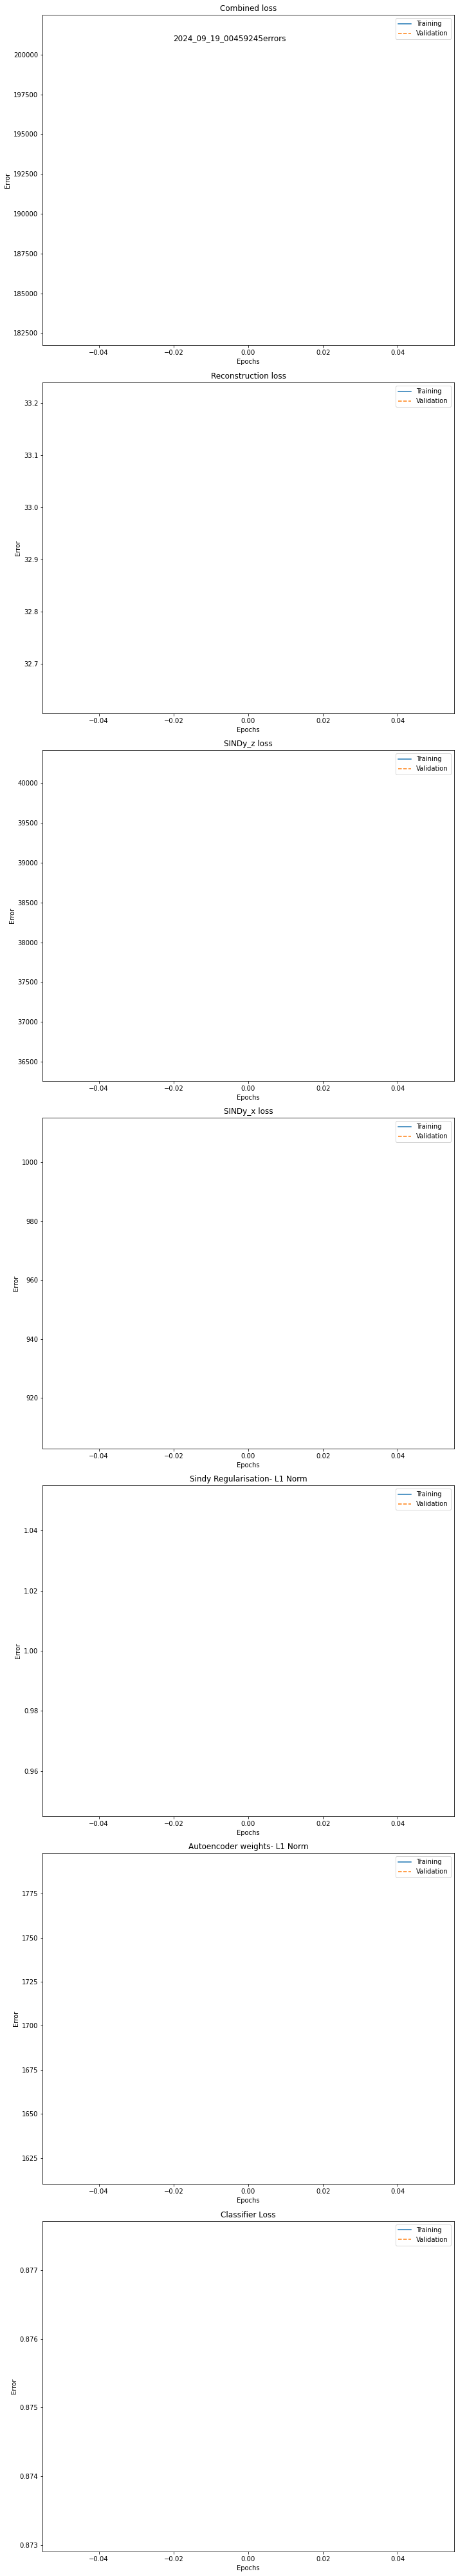

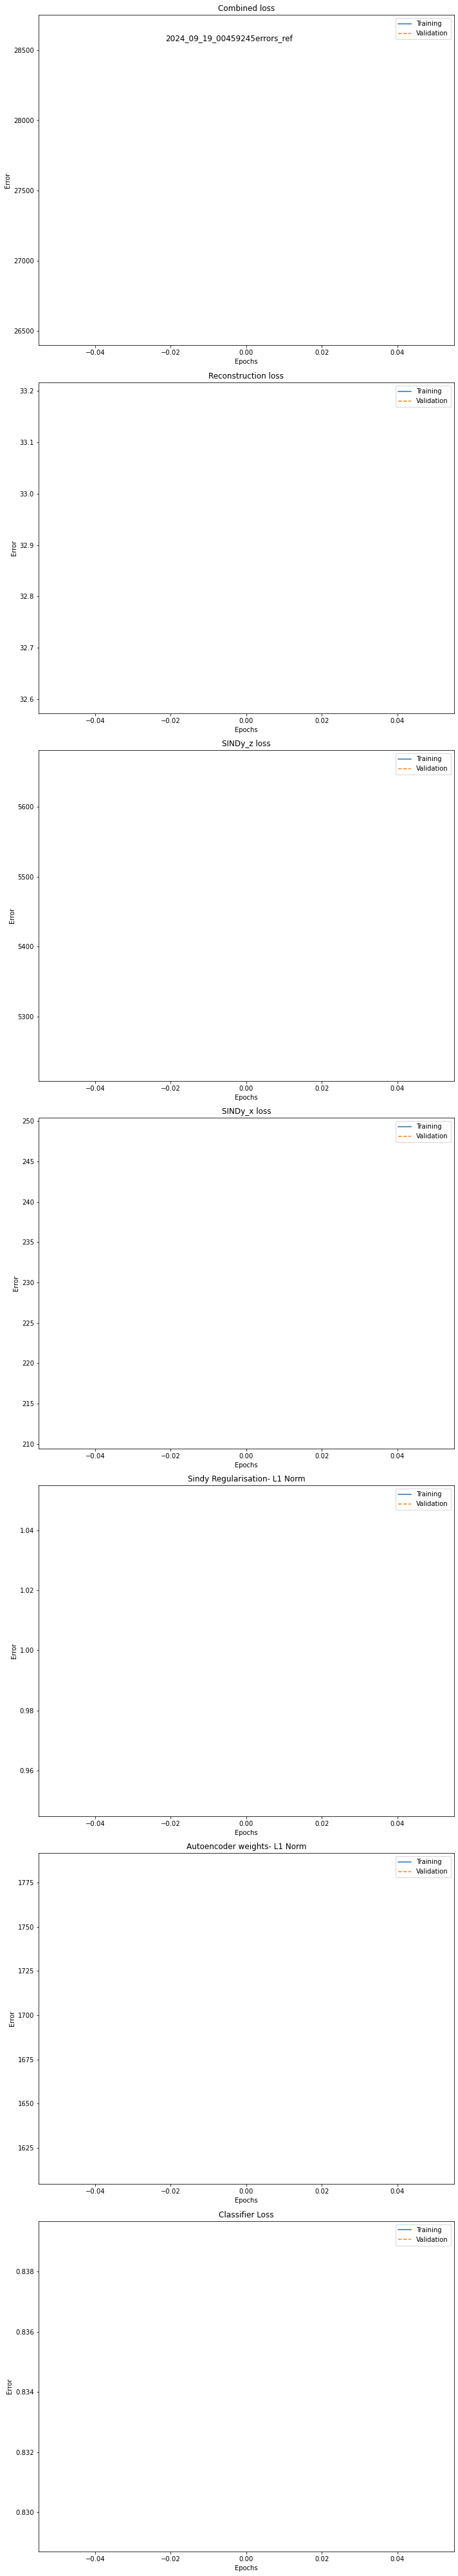

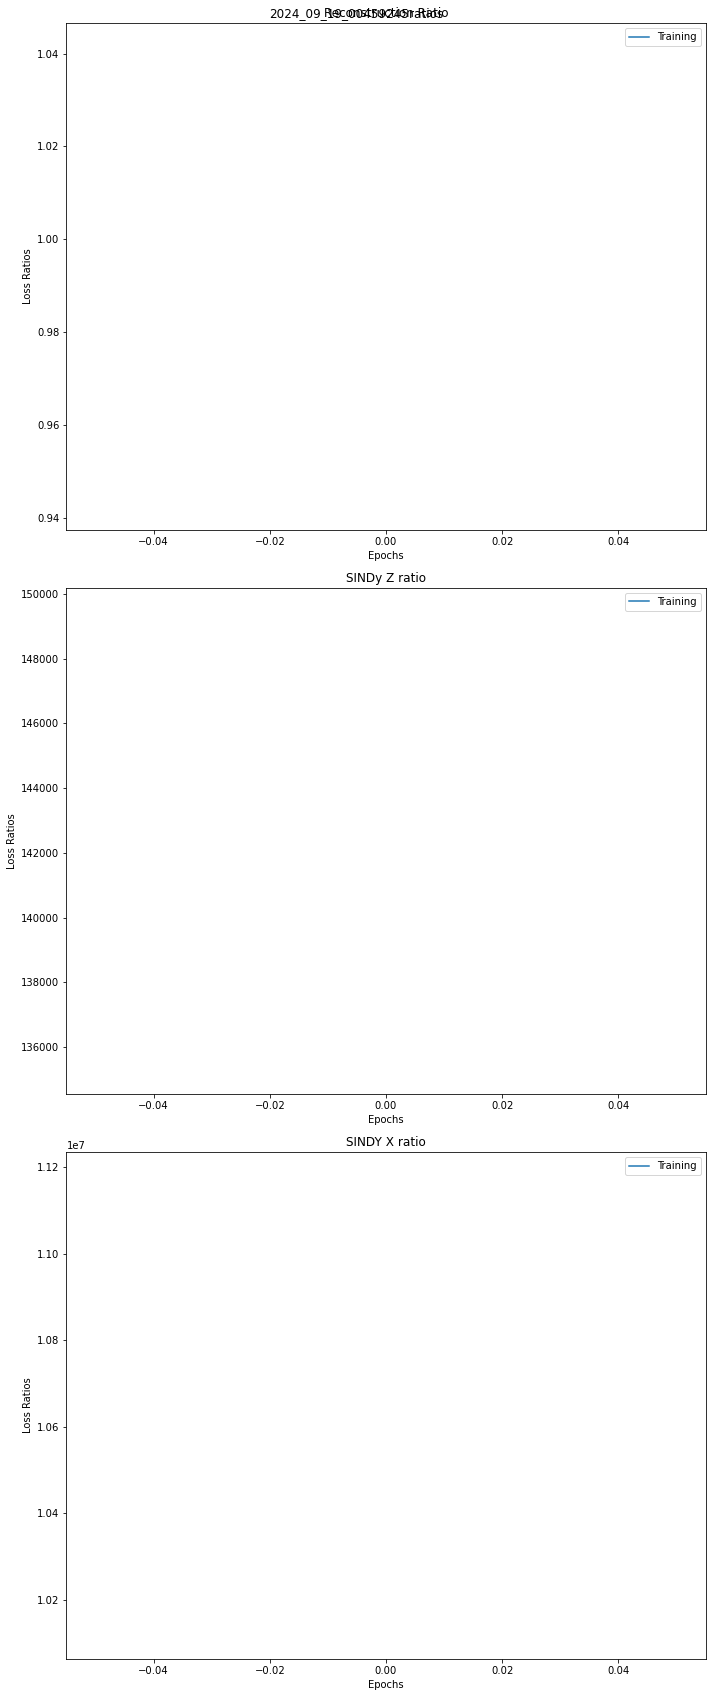

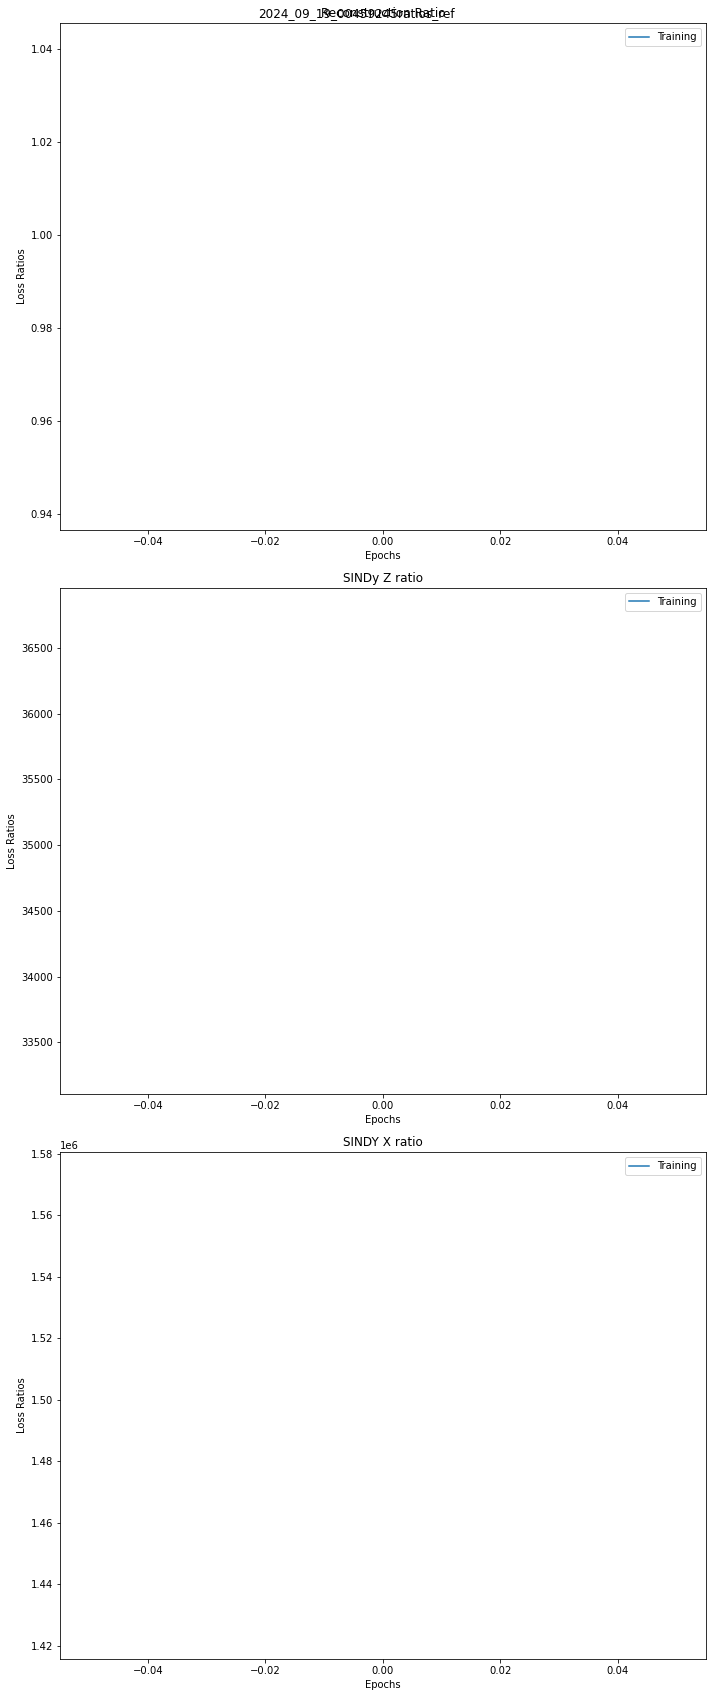

In [48]:
latent_dim=6
params['model']='SERGIO'
params['input_dim'] = 100
params['latent_dim'] =6
params['model_order'] = 1
params['poly_order'] = 2
params['include_sine'] = True
params['include_constant']=True
#The below inclide parameters have only been simulated for model_order 1 for now
if params['model_order']==1:
    params['include_tan']=False
    params['include_log']=False #this can be modified later such that the domain restirctions of log doesnt become a problem. For now it is kept to false.
    params['include_exp']=True
    params['include_reciprocal_func']=True
else:
    params['include_tan']=False
    params['include_log']=False
    params['include_exp']=True
    params['include_reciprocal_func']=False
params['library_dim'] = library_size(n=params['latent_dim'], poly_order=params['poly_order'], use_sine=params['include_sine'], include_constant=params['include_constant'],use_tan=params['include_tan'],use_log=params['include_log'],use_exp=params['include_exp'],use_reciprocal=params['include_reciprocal_func'])



# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 200
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

# loss function weighting
params['loss_weight_decoder'] = 10
params['loss_weight_sindy_z'] = 5
params['loss_weight_sindy_x'] = 0.1
params['loss_weight_sindy_regularization'] =1
params['autoencoder_regularization']=1e-5

params['weights']=[params['loss_weight_decoder'],params['loss_weight_sindy_z'],params['loss_weight_sindy_x'],params['loss_weight_sindy_regularization'],params['autoencoder_regularization'], params['latent_dim'],params['coefficient_threshold']]

params['activation'] = 'relu'
params['widths'] = [64,32]
# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = training_data['x'].shape[0]
params['learning_rate'] =1e-3
params['print_progress'] = True
params['print_frequency'] = 50

params['num_classes']=9
# training time cutoffs
params['max_epochs'] = 1
params['refinement_epochs'] =1
params['terms']=4*latent_dim+6 # put as None if the training should go for entire epoch defined. If the number of active terms go below this, the training stops


#classifier parameters
params['classify']=True
params['classifier_widths']=[12]
params['weights']=params['weights']+[params['classifier_widths']]
params['loss_class']=0.5
num_experiments = 1

df = pd.DataFrame()
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)
    params['encoder_weights']=build_network_layers(params['input_dim'], params['latent_dim'], params['widths'], 'encoder')
    params['decoder_weights']=build_network_layers(params['latent_dim'], params['input_dim'], params['widths'][::-1], 'decoder')
    params['classifier_weights']=build_network_layers( params['latent_dim'], params['num_classes'], params['classifier_widths'], 'encoder')


    #This can be changed while retraining to hold some variables zero 
    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
    
    params['folder'] = params['model']+str(params['widths'])+str(params['weights'])+str(params['learning_rate'])
    params['save_name']=datetime.datetime.now().strftime("%Y_%m_%d_%H%f")
    params['coefficient_initialization'] = 'specified'

    params['init_coefficients']=np.asarray(np.random.choice([-1, 1], size=(params['library_dim'], params['latent_dim'])), dtype=np.float32)

    # Create a save folder if it doesn't exist
    save_folder = os.path.join(params['data_path'], params['folder'])
    params['save_folder']=save_folder+"\\"
    os.makedirs(save_folder, exist_ok=True)
    os.chdir(save_folder)
    tf.reset_default_graph()

    # Train the network and obtain results
    results_dict = train_network(training_data, validation_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)

# Change back to the original data path
os.chdir(params['data_path'])    
# Save the DataFrame to a pickle file with a timestamped filename
df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')